In [1]:
import numpy as np
from astropy import coordinates as coo
from astropy import units as u
import healpy as hp
import matplotlib.pyplot as plt
import multiprocessing as mp
from astropy.io import fits

In [2]:
from data_process import weight_nan_mean, load_calculation_data, calculate_jackknife_variance

In [3]:
Nside_jack = 4

In [4]:
r_p, dat = load_calculation_data('../calculation_data/result_r=3_100_15_quasar_lss_CMB_lcut_n_2048_tree.npy', return_rp=True)
dat_r = load_calculation_data('../calculation_data/result_r=3_100_15_random_quasar_lss_CMB_lcut_n_2048_tree.npy')

In [5]:
zmin = 1.5
zmax = 2
suffix = 'h_2048'

In [6]:
value = dat[0]
weight = dat[1]
value_r = dat_r[0]
weight_r = dat_r[1]


quasar_cata = np.load('../catalogue/quasar_lss.npy')
c = coo.SkyCoord(ra=quasar_cata['ra']*u.degree, dec=quasar_cata['dec']*u.degree)
l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pix = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)
index_h = np.logical_and(quasar_cata['z']>zmin, quasar_cata['z']<zmax)              # TODO: l, h

value = value[index_h]
weight = weight[index_h]
pix = pix[index_h]

print('finish loading quasar catalogue')

random_sample = np.load('../catalogue/random_quasar_lss.npy')
c = coo.SkyCoord(ra=random_sample['ra']*u.degree, dec=random_sample['dec']*u.degree)
assert (random_sample['w']==1).all()
l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pix_r = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

index_h = np.logical_and(random_sample['z']>zmin, random_sample['z']<zmax)        # TODO change this
pix_r = pix_r[index_h]
value_r = value_r[index_h]
weight_r = weight_r[index_h]

print('finish loading random sample')

finish loading quasar catalogue
finish loading random sample


In [7]:
savefig = False

## quasar sample

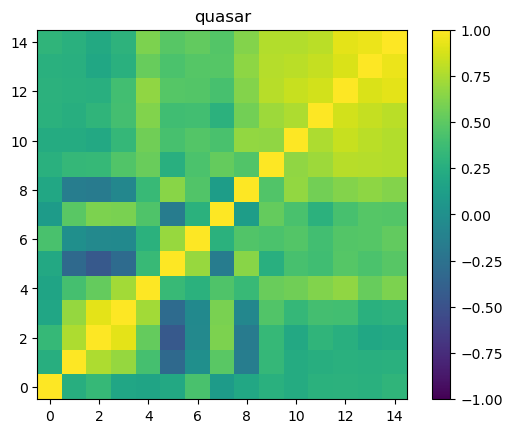

In [8]:
sampler_q = calculate_jackknife_variance(value, weight, pix, norm_cov=True)

plt.imshow(sampler_q['cov'], origin='lower', vmin=-1, vmax=1)
plt.colorbar()
plt.title('quasar')
if savefig:
    plt.savefig('./fig/cov_q')
plt.show()

## random sample

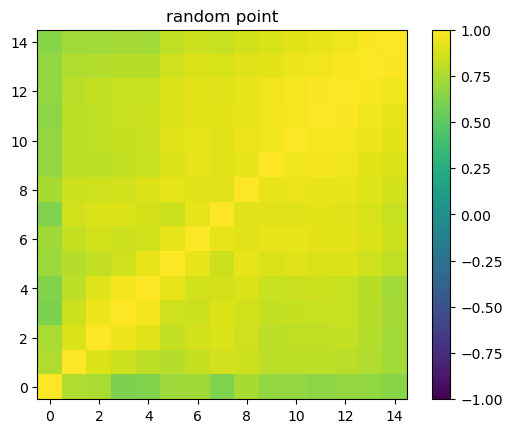

In [10]:
sampler_r = calculate_jackknife_variance(value_r, weight_r, pix_r, norm_cov=True)

plt.imshow(sampler_r['cov'], origin='lower', vmin=-1, vmax=1)
plt.title('random point')
plt.colorbar()
if savefig:
    plt.savefig('./fig/cov_r')
plt.show()

## quasar - random

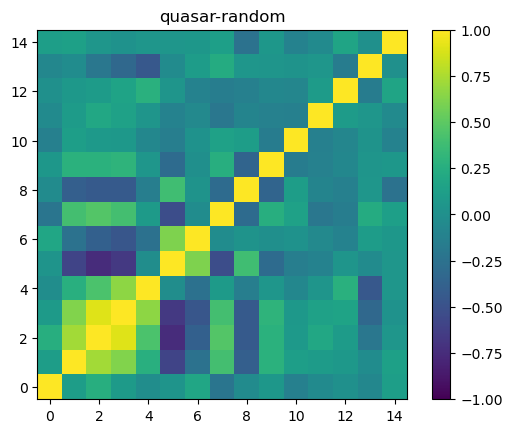

In [9]:
sampler_sub = calculate_jackknife_variance(value, weight, pix, value_r, weight_r, pix_r, norm_cov=True)
plt.imshow(sampler_sub['cov'], origin='lower', vmin=-1, vmax=1)
plt.title('quasar-random')
plt.colorbar()
if savefig:
    plt.savefig('./fig/cov_qr')
plt.show()

## signal

In [12]:
np.savetxt(f'quasar_lss_sigma_{suffix}', np.c_[r_p, sampler_sub['mean'], sampler_sub['std']])

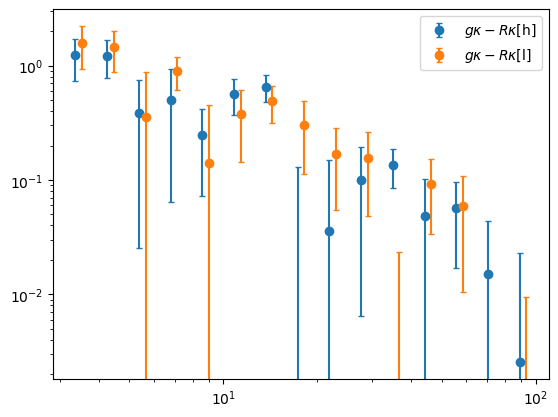

In [24]:
res_h = np.loadtxt('quasar_lss_sigma_h')
res_l = np.loadtxt('quasar_lss_sigma_l')
r_p = res_h[:,0]
plt.errorbar(r_p, res_h[:,1], res_h[:,2], capsize=2, fmt='o', label='$g\\kappa-R\\kappa$[h]')
plt.errorbar(r_p*1.05, res_l[:,1], res_l[:,2], capsize=2, fmt='o', label='$g\\kappa-R\\kappa$[l]')
plt.loglog()
plt.legend()
# plt.savefig('./fig/quasar_lss_1_sigma')

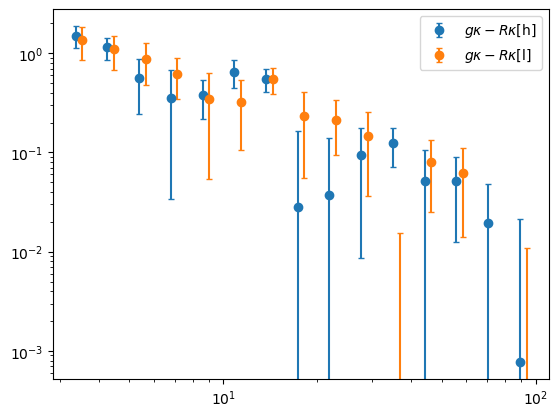

In [23]:
res_h_2048 = np.loadtxt('quasar_lss_sigma_h_2048')
res_l_2048 = np.loadtxt('quasar_lss_sigma_l_2048')
r_p = res_h_2048[:,0]
plt.errorbar(r_p, res_h_2048[:,1], res_h_2048[:,2], capsize=2, fmt='o', label='$g\\kappa-R\\kappa$[h]')
plt.errorbar(r_p*1.05, res_l_2048[:,1], res_l_2048[:,2], capsize=2, fmt='o', label='$g\\kappa-R\\kappa$[l]')
plt.loglog()
plt.legend()
# plt.savefig('./fig/quasar_lss_1_sigma')

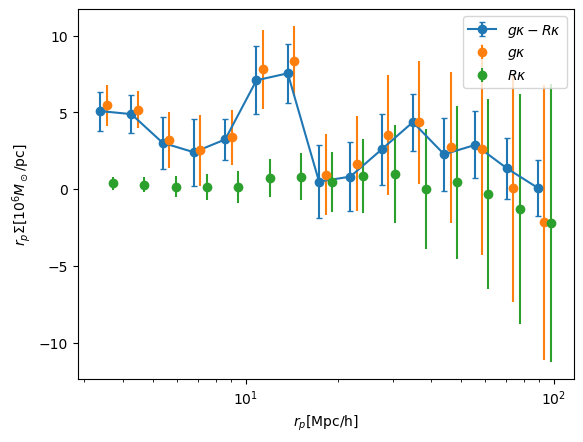

In [17]:
r_p = dp.r_p
plt.errorbar(r_p, r_p*sampler_sub.mean, r_p*sampler_sub.std, capsize=2, fmt='-o', label='$g\\kappa-R\\kappa$')
plt.errorbar(r_p*1.05, r_p*sampler_q.mean, r_p*sampler_q.std, label='$g\\kappa$', fmt='o')
plt.errorbar(r_p*1.05*1.05, r_p*sampler_r.mean, r_p*sampler_r.std, label='$R\\kappa$', fmt='o')
plt.semilogx()
plt.xlabel('$r_p[\\mathrm{Mpc/h}]$')
plt.ylabel('$r_p\\Sigma[10^6 M_\\odot/\\mathrm{pc}]$')
# plt.ylim(top=50)
plt.legend()
if savefig:
    plt.savefig('./fig/quasar_random.jpg')
plt.show()

# for i in range(jack_val_q.shape[1]):
#     plt.plot(r_p, r_p*jack_val_q[i], '--')
# for i in range(jack_val_r.shape[1]):
#     plt.plot(r_p, r_p*jack_val_r[i], '-.')

# plt.semilogx()
# plt.xlabel('$r_p[\\mathrm{Mpc/h}]$')
# plt.ylabel('$r_p\\Sigma[10^6 M_\\odot/\\mathrm{pc}]$')

if savefig:
    plt.savefig('./fig/quasar_random_jack.jpg')
plt.show()